# Autoregressive Flows 

1.  The Core Idea: The Autoregressive Property

The foundation of autoregressive models is the **chain rule of probability**. For any ordering of the dimensions of a vector $\mathbf{x}=(x_1,\dots,x_D)$, the joint probability can be factored into a product of one-dimensional conditional probabilities:

$$p(x_1,\dots,x_D)=\prod_{i=1}^{D}p(x_i|x_1,\dots,x_{i-1})$$

This powerful rule tells us that we can model a complex, high-dimensional joint distribution by breaking it down into a sequence of simpler, one-dimensional conditional distributions. Each variable $x_i$ only needs to be conditioned on the variables that came before it in the chosen sequence.

Our goal is to design a normalizing flow that explicitly respects this conditional structure, allowing for very expressive transformations.

2.  Masked Autoregressive Flow (MAF)

This type of flow is specifically designed for **fast likelihood evaluation**.

### Theory

A Masked Autoregressive Flow (MAF) defines a transformation where the parameters for transforming a latent variable $z_i$ into a data variable $x_i$ depend on the **previous data dimensions** $x_{1:i-1}$.

* **Forward Transformation (Sampling):** The mapping from the latent space to the data space is defined as: $x_i=h(z_i,g_i(x_{1:i-1},w_i))$. Here, $g_i$ is the conditioner network that computes the parameters (e.g., scale and shift) for the simple, invertible coupling function $h$ (like the affine transformation from RealNVP).
* **Inverse Transformation (Likelihood):** The mapping from the data space to the latent space is: $z_i=h^{-1}(x_i,g_i(x_{1:i-1},w_i))$

### The Critical Asymmetry (MAF)

The way MAF is structured creates a crucial performance asymmetry:

* **Likelihood Calculation (Fast):** To evaluate the likelihood of a given data point $\mathbf{x}$, we need to compute its corresponding $\mathbf{z}$. Since all components $(x_1,\dots,x_D)$ are known, we can compute all the conditioner outputs $g_i(x_{1:i-1})$ in parallel. Once the scale and shift parameters for every dimension are ready, all the inverse transformations $h^{-1}$ to find each $z_i$ can also be performed **in parallel**. This makes likelihood evaluation very efficient.
* **Sampling (Slow):** To generate a new sample $\mathbf{x}$, we must proceed **sequentially**. We sample the full vector $\mathbf{z}$ from the base distribution. Then:
    * We compute $x_1$ from $z_1$ (since it depends on no prior dimensions).
    * We use this new $x_1$ to compute the parameters for the transformation of $z_2$, giving us $x_2$.
    * We use $x_1$ and $x_2$ to compute parameters for $z_3$, giving us $x_3$.
    * ...and so on. This is an inherently serial process ($x_1 \rightarrow x_2 \rightarrow \dots \rightarrow x_D$) and can be very slow for high-dimensional data.

### Implementation Concept: Masking

The main implementation challenge is to compute all conditioner outputs $g_i(x_{1:i-1})$ efficiently. Instead of using $D$ separate neural networks, a single, larger network is used with carefully constructed **binary masks** on its weights. This is the core idea of the **MADE (Masked Autoencoder for Distribution Estimation)** architecture.

By assigning a "degree" to each neuron and masking connections to ensure a neuron can only receive input from neurons of a lower degree, the network can compute all conditional parameters in a single forward pass while strictly enforcing the autoregressive property.

3.  Inverse Autoregressive Flow (IAF)

This type of flow is the inverse of MAF and is designed for **fast sampling**.

### Theory

An Inverse Autoregressive Flow (IAF) defines a transformation where the parameters for generating $x_i$ depend on the **previous latent dimensions** $z_{1:i-1}$.

* **Forward Transformation (Sampling):** $x_i=h(z_i,g_i(z_{1:i-1},w_i))$
* **Inverse Transformation (Likelihood):** $z_i=h^{-1}(x_i,g_i(z_{1:i-1},w_i))$ Notice the problem here: to find $z_i$, you need $z_{1:i-1}$, which you don't have yet.

### The Critical Asymmetry (IAF)

* **Sampling (Fast):** When sampling, we begin by drawing the entire latent vector $\mathbf{z}$ from the base distribution. Since all its components $(z_1,\dots,z_D)$ are known, all conditioner outputs $g_i(z_{1:i-1})$ can be computed **in parallel**. The subsequent transformations to get the full data vector $\mathbf{x}$ can also be done in parallel. This makes sampling extremely efficient.
* **Likelihood Calculation (Slow):** To evaluate the likelihood of a data point $\mathbf{x}$, we must find its corresponding $\mathbf{z}$ sequentially. We first find $z_1$ from $x_1$. Then we must use this $z_1$ to help find $z_2$ from $x_2$, and so on. This serial dependency makes likelihood evaluation slow.

4.  Summary & Connection to Coupling Flows

The trade-off between fast sampling and fast likelihood evaluation is the central theme of autoregressive flows.

| Flow Type | Likelihood Evaluation | Sampling | Primary Use Case                         |
| :-------- | :-------------------- | :------- | :--------------------------------------- |
| MAF       | Fast (Parallel)       | Slow (Sequential) | Maximum Likelihood Density Estimation    |
| IAF       | Slow (Sequential)     | Fast (Parallel) | Fast generation of samples (e.g., in a VAE decoder) |
| RealNVP   | Fast (Parallel)       | Fast (Parallel) | A practical compromise; good at both tasks |

As the table shows, **Coupling Flows (like RealNVP) are a practical and powerful compromise.** By partitioning variables into just two groups ($\mathbf{z}_A$ and $\mathbf{z}_B$) instead of $D$ individual variables, they sacrifice some of the potential expressive power of a fully autoregressive model but gain the significant benefit of being fast in **both** directions.
```

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, MultivariateNormal
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import sys
import time
sys.path.append('../')
from src.flows.autoregressive import MaskedAutoregressiveFlow, InverseAutoregressiveFlow, MADE
from src.models import NormalizingFlowModel
from src.flows.spline import ARQS
from src.utils import get_two_moons_data, plot_enhanced_visualizations
from src.flows.flow import SequentialFlow

def train(model, optimizer, data_loader, epochs, base_dist, flow_type, max_grad_norm):
    """
    Main training loop for the Autoregressive Flow model.
    """
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',    # Reduce on loss stagnation
    factor=0.1,    # Reduce LR by a factor of 10
    patience=10,   # Wait 10 epochs before reducing
    )
    model.train()
    print(f"Starting training for {flow_type}...")
    for epoch in range(epochs):
        total_loss = 0
        for i, x in enumerate(data_loader):
            optimizer.zero_grad()
            
            # The inverse pass maps data to the latent space for likelihood calculation.
            z, log_det = model.inverse(x)
            
            # Calculate the negative log-likelihood loss
            # log p(x) = log p(z) + log|det(J)|
            log_prob_z = base_dist.log_prob(z)
            loss = -(log_prob_z + log_det).mean()
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm) 
            
            optimizer.step()
            scheduler.step(loss)
            total_loss += loss.item()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(data_loader):.4f}')
    print("Training finished.")

def visualize_and_time(model, base_dist, flow_type, num_samples=5000):
    """
    Generates samples, plots them, and times the forward and inverse passes.
    """
    model.eval()
    with torch.no_grad():
        # --- Visualization ---
        z_samples = base_dist.sample((num_samples,))
        
        print(f"[{flow_type}] Generating samples (forward pass)...")
        start_time = time.time()
        x_samples, _ = model.forward(z_samples)
        forward_time = time.time() - start_time
        print(f"[{flow_type}] Sampling complete in {forward_time:.4f} seconds.")

        # --- Timing the inverse pass (Likelihood Evaluation) ---
        print(f"[{flow_type}] Evaluating likelihood (inverse pass)...")
        start_time = time.time()
        _, _ = model.inverse(x_samples)
        inverse_time = time.time() - start_time
        print(f"[{flow_type}] Likelihood evaluation complete in {inverse_time:.4f} seconds.")

        return forward_time, inverse_time


In [2]:

# --- Main Execution ---
input_dim = 2
n_layers = 8
hidden_dim =  128
learning_rate = 1e-4
n_epochs = 200
batch_size = 1024
n_samples = 20000
max_grad_norm = 10.0

device = torch.device('cpu')
data = get_two_moons_data(n_samples=n_samples).to(device)
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

base_dist = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))


In [3]:

# --- MAF Model ---
maf_flows = [MaskedAutoregressiveFlow(dim=input_dim, hidden_dim=hidden_dim) for _ in range(n_layers)]
maf_model = SequentialFlow(maf_flows).to(device)
maf_optimizer = optim.Adam(maf_model.parameters(), lr=learning_rate)

train(maf_model, maf_optimizer, data_loader, n_epochs, base_dist, flow_type='MAF',max_grad_norm=max_grad_norm)
maf_forward_time, maf_inverse_time = visualize_and_time(maf_model, base_dist, 'MAF')


Starting training for MAF...
Epoch 10/200, Loss: -4.4059
Epoch 20/200, Loss: 202.0052
Epoch 30/200, Loss: -16.1596
Epoch 40/200, Loss: -16.5628
Epoch 50/200, Loss: -16.5633
Epoch 60/200, Loss: -16.5579
Epoch 70/200, Loss: -16.5615
Epoch 80/200, Loss: -16.5614
Epoch 90/200, Loss: -16.5625
Epoch 100/200, Loss: -16.5608
Epoch 110/200, Loss: -16.5618
Epoch 120/200, Loss: -16.4978
Epoch 130/200, Loss: -16.5636
Epoch 140/200, Loss: -16.5635
Epoch 150/200, Loss: -16.5637
Epoch 160/200, Loss: -16.5639
Epoch 170/200, Loss: -16.5642
Epoch 180/200, Loss: -16.5649
Epoch 190/200, Loss: -16.5649
Epoch 200/200, Loss: -16.5650
Training finished.
[MAF] Generating samples (forward pass)...
[MAF] Sampling complete in 0.0266 seconds.
[MAF] Evaluating likelihood (inverse pass)...
[MAF] Likelihood evaluation complete in 0.0137 seconds.


In [6]:

# --- IAF Model ---
iaf_flows = [InverseAutoregressiveFlow(dim=input_dim, hidden_dim=hidden_dim) for _ in range(n_layers)]
iaf_model = SequentialFlow(iaf_flows).to(device)
iaf_optimizer = optim.Adam(iaf_model.parameters(), lr=learning_rate)
train(iaf_model, iaf_optimizer, data_loader, n_epochs, base_dist, flow_type='IAF',max_grad_norm=max_grad_norm)
iaf_forward_time, iaf_inverse_time = visualize_and_time(iaf_model, base_dist, 'IAF')


Starting training for IAF...
Epoch 10/200, Loss: 1.7590
Epoch 20/200, Loss: 1.7504
Epoch 30/200, Loss: 1.7519
Epoch 40/200, Loss: 1.7512
Epoch 50/200, Loss: 1.7509
Epoch 60/200, Loss: 1.7519
Epoch 70/200, Loss: 1.7522
Epoch 80/200, Loss: 1.7511
Epoch 90/200, Loss: 1.7513
Epoch 100/200, Loss: 1.7526
Epoch 110/200, Loss: 1.7517
Epoch 120/200, Loss: 1.7512
Epoch 130/200, Loss: 1.7518
Epoch 140/200, Loss: 1.7522
Epoch 150/200, Loss: 1.7515
Epoch 160/200, Loss: 1.7508
Epoch 170/200, Loss: 1.7513
Epoch 180/200, Loss: 1.7510
Epoch 190/200, Loss: 1.7506
Epoch 200/200, Loss: 1.7509
Training finished.
[IAF] Generating samples (forward pass)...
[IAF] Sampling complete in 0.0154 seconds.
[IAF] Evaluating likelihood (inverse pass)...
[IAF] Likelihood evaluation complete in 0.0283 seconds.


In [5]:

# --- Performance Comparison ---
print("\n--- Performance Comparison ---")
print(f"MAF - Sampling (Forward): {maf_forward_time:.4f}s | Likelihood (Inverse): {maf_inverse_time:.4f}s")
print(f"IAF - Sampling (Forward): {iaf_forward_time:.4f}s | Likelihood (Inverse): {iaf_inverse_time:.4f}s")


--- Performance Comparison ---
MAF - Sampling (Forward): 0.0353s | Likelihood (Inverse): 0.0168s
IAF - Sampling (Forward): 0.0169s | Likelihood (Inverse): 0.0358s



--- MAF Model Visualizations ---


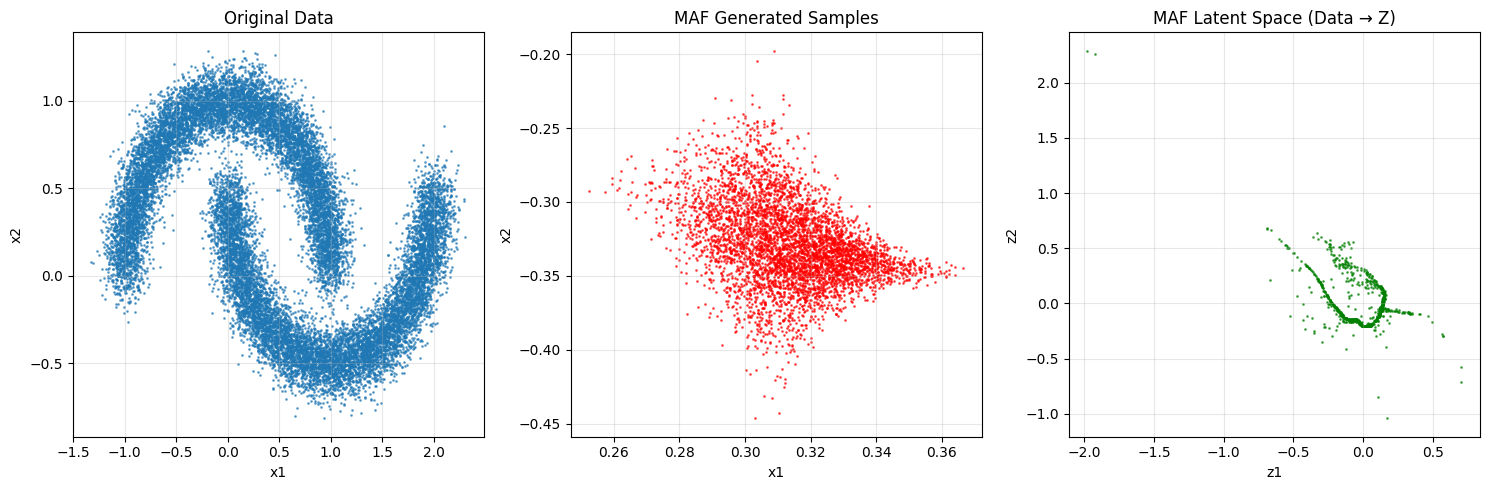

In [5]:
print("\n--- MAF Model Visualizations ---")
plot_enhanced_visualizations(maf_model, data, base_dist, 'MAF', device)


--- IAF Model Visualizations ---


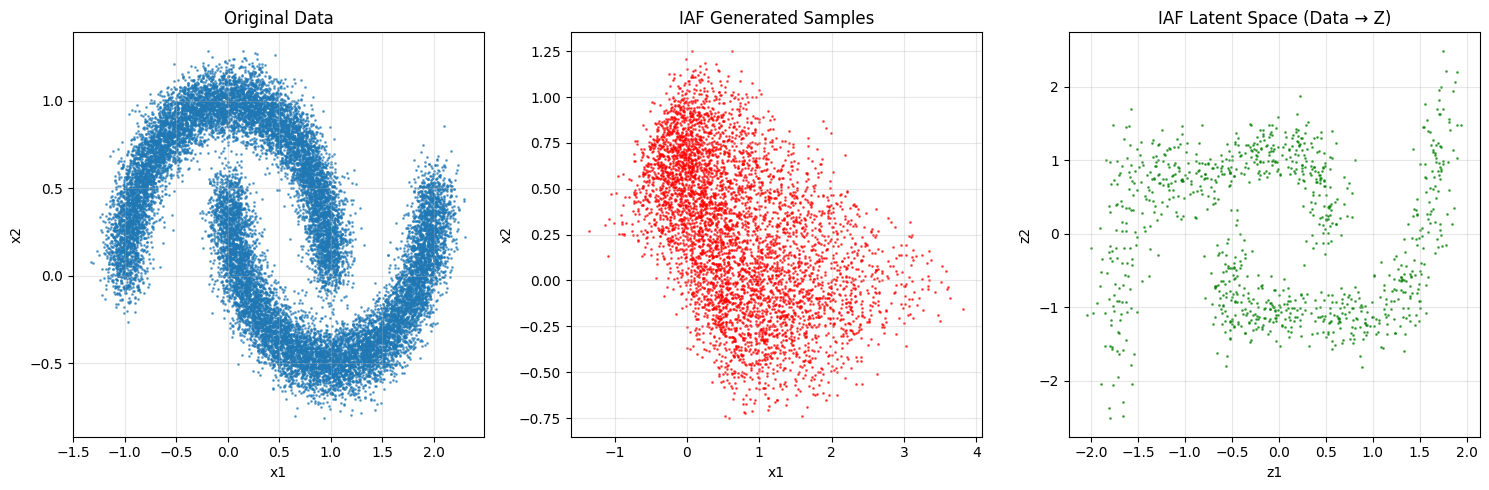

In [7]:


print("\n--- IAF Model Visualizations ---")
plot_enhanced_visualizations(iaf_model, data, base_dist, 'IAF', device)

In [8]:
from src.utils import diagnose_flow_model
diagnose_flow_model(maf_model, data, base_dist, 'MAF', device)


=== MAF Diagnostics ===
Forward pass - x range: [-0.373, 0.353]
Forward pass - x mean: tensor([ 0.3149, -0.3279])
Forward pass - x std: tensor([0.0180, 0.0230])
Forward pass - log_det range: [-9.546, -7.475]
Inverse pass - z range: [-1.042, 0.663]
Inverse pass - z mean: tensor([ 0.0144, -0.0076])
Inverse pass - z std: tensor([0.1933, 0.2291])
Inverse pass - log_det range: [17.514, 19.528]
Round-trip error (z → x → z): 0.963367
Identity error (z ≈ x): 0.989381


{'forward_stats': {'range': (-0.3727496862411499, 0.35327377915382385),
  'mean': [0.3148854076862335, -0.3279228210449219],
  'std': [0.01803644374012947, 0.022951170802116394]},
 'inverse_stats': {'range': (-1.0418117046356201, 0.662666916847229),
  'mean': [0.014417486265301704, -0.007588997483253479],
  'std': [0.19333747029304504, 0.22905601561069489]},
 'roundtrip_error': 0.9633665680885315,
 'identity_error': 0.9893807768821716}